# Baseline Refresh Code Example

In this code we show how to implement a baseline refresh for the different exposure methods

1. Import modules

In [48]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import tkinter

In [49]:
def PSR_NGR(positions, addonfactor, singleposition):

    GrossExposure = 0
    CurrentExposure = 0
    NetExposure = 0
    AddOn_Gross = 0

    if singleposition == True:
        GrossExposure += max(0, positions[0])
        CurrentExposure += positions[0]
        AddOn_Gross += addonfactor * positions[1]
    else:
        for i in range(len(positions)):
            GrossExposure += max(0, positions[i,0])
            CurrentExposure += positions[i,0]
            AddOn_Gross += addonfactor * positions[i,1]

    NetExposure = max(0, CurrentExposure)

    if GrossExposure == 0:
        NGR = 0
    else:
        NGR = NetExposure/GrossExposure
    
    PSR = max(0, CurrentExposure) + NGR * (0.6) * (AddOn_Gross) + (0.4) * (AddOn_Gross)

    return PSR



def PSR_Conservative(positions, addonfactor):

    total_PSR_NGR = 0
    singleposition = True

    for i in range(len(positions)):
        total_PSR_NGR += PSR_NGR(positions[i,:], addonfactor, singleposition)
    
    return total_PSR_NGR

def PSR_Linear(positions, addonfactor):

    total_PSR_NGR = 0

    base_PSR_NGR = 0
    singleposition = True
    sample = positions[0,:]
    base_PSR_NGR += PSR_NGR(sample, addonfactor, singleposition)
    total_PSR_NGR = base_PSR_NGR

    singleposition = False

    for i in range(len(positions)-1):
        total_PSR_NGR += (PSR_NGR(positions[[0,i+1], :], addonfactor, singleposition) - base_PSR_NGR)

    return total_PSR_NGR


def PSR_Average(positions, addonfactor, n):

    total_PSR_NGR = 0
    base_PSR_NGR = 0

    singleposition = True
    base_PSR_NGR += PSR_NGR(positions[0,:], addonfactor, singleposition)
    total_PSR_NGR = base_PSR_NGR

    singleposition = False

    for i in range(len(positions)-1):

        # take out the baseline position and the x_i position
        trade_i = positions[[0,i+1], :]
        
        # multiply the i-th position by n - as it happens in the formula
        trade_i[1,:] *= n

        # multiply the formula by n
        total_PSR_NGR += 1/n*(PSR_NGR(trade_i, addonfactor, singleposition) - base_PSR_NGR)


    return total_PSR_NGR

[1030.0, 622.8, 1145.0, 895.7727272727274, 796.9272727272728, 1953.0]


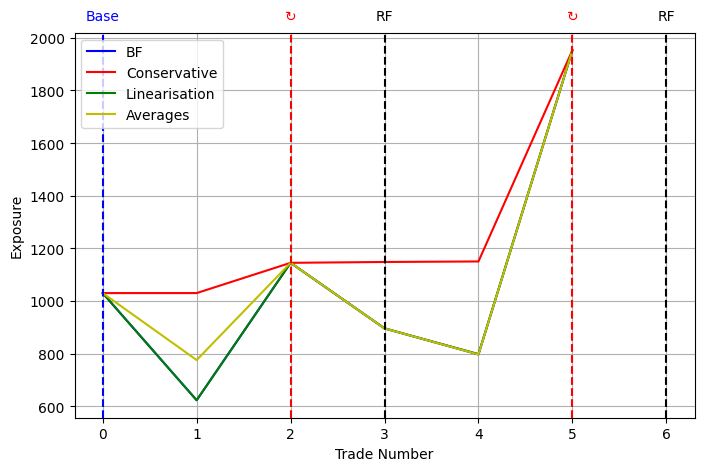

Positions Matrix 
 [[ 1850. 10300.]
 [ -400.     0.]
 [ -250.   800.]
 [ -100.   500.]
 [  300.  1200.]]


BF list  [1030.0, 622.8, 1145.0, 895.7727272727274, 796.9272727272728, 1953.0]
Lin List [1030.0, 622.8, 1145.0, 895.7727272727274, 798.0454545454546, 1953.0]


Conservative List [1030.0, 1030.0, 1145.0, 1148.2, 1150.2, 1953.0]
Average List [1030.0, 775.5, 1145.0, 895.7727272727274, 796.6818181818182, 1953.0]


In [50]:


def get_position_impacts(n):
    
    baseline_position = [1000, 100000]
    mtm_notional_matrix = np.zeros((n,2))

    
    for i in range(n):

        mtm_notional_matrix[i,0] = random.randint(-200,200)
        mtm_notional_matrix[i,1] = abs(10*mtm_notional_matrix[i,0])
    
    positions = np.vstack([baseline_position, mtm_notional_matrix])
    
    return positions

position_impacts_state = {"n": 0, "data": None}

def update_position_impacts(n):
    global position_impacts_state
    if position_impacts_state["n"] != n:
        position_impacts_state["n"] = n
        position_impacts_state["data"] = get_position_impacts(n)


def get_position_impacts_test(n=4):

    #baseline_position = [400, 2000]
    #mtm_notional_matrix = np.zeros((n,4))

    #mtm_notional_matrix[0,0] = 300
    #mtm_notional_matrix[1,0] = -400
    #mtm_notional_matrix[2,0] = 400
    #mtm_notional_matrix[3,0] = -400

    #mtm_notional_matrix[0,1] = 1000
    #mtm_notional_matrix[1,1] = 1000
    #mtm_notional_matrix[2,1] = 1000
    #mtm_notional_matrix[3,1] = 0

    baseline_position = [500, 1500]
    mtm_notional_matrix = np.zeros((n,2))

    mtm_notional_matrix[1,0] = -250
    mtm_notional_matrix[3,0] = 300
    mtm_notional_matrix[2,0] = -100
    mtm_notional_matrix[0,0] = -400

    mtm_notional_matrix[1,1] = 800
    mtm_notional_matrix[3,1] = 1200
    mtm_notional_matrix[2,1] = 500
    mtm_notional_matrix[0,1] = 0

    positions = np.vstack([baseline_position, mtm_notional_matrix])
    
    return positions


def exposure_simulation(n,m, addonfactor):
    
    
    #update_position_impacts(n)
    #positions = position_impacts_state["data"]
    
    positions = get_position_impacts_test(n)

    singleposition = False

    bf_list = []
    cons_list = []
    lin_list = []
    avg_list = []

    for i in range(int(n/m)):
        
        cumulative_positions = np.zeros((0, 2))  # empty to start
        cumulative_positions = np.vstack([cumulative_positions, positions[0, :]])

        for j in range(m):
            
            # Add the next position to the cumulative set
            cumulative_positions = np.vstack([cumulative_positions, positions[j + m*i, :]])

            # Perform the PSR calculations for each strategy
            NGR_BF = PSR_NGR(cumulative_positions, addonfactor, singleposition)
            NGR_Lin = PSR_Linear(cumulative_positions, addonfactor)
            NGR_Cons = PSR_Conservative(cumulative_positions, addonfactor)
            NGR_Avg = PSR_Average(cumulative_positions, addonfactor, j + 1)

            # Append results to respective lists
            bf_list.append(NGR_BF)
            lin_list.append(NGR_Lin)
            cons_list.append(NGR_Cons)
            avg_list.append(NGR_Avg)

        mtmRefresh = positions[0,0] + np.sum(cumulative_positions[:,0])
        notionalRefresh = positions[0,1] + np.sum(cumulative_positions[:,1])

        positions[0,0] = max(0,mtmRefresh)
        positions[0,1] = notionalRefresh

        bf_list.append(PSR_NGR(np.array([positions[0,:]]), addonfactor, singleposition))
        lin_list.append(PSR_NGR(np.array([positions[0,:]]), addonfactor, singleposition))
        cons_list.append(PSR_NGR(np.array([positions[0,:]]), addonfactor, singleposition))
        avg_list.append(PSR_NGR(np.array([positions[0,:]]), addonfactor, singleposition))

    print(bf_list)
    x = np.linspace(0, n+int(n/m)-1, n+int(n/m))


    if n % m == 0:
        
        plt.figure(figsize=(8,5))
        plt.grid(True)
        plt.plot(x, bf_list, 'b', label = "BF")
        plt.plot(x, cons_list, 'r', label = "Conservative")
        plt.plot(x, lin_list, 'g', label = "Linearisation")
        plt.plot(x, avg_list, 'y', label = "Averages")
        plt.xlabel("Trade Number")
        plt.ylabel("Exposure")


        for i in range(int(n/m)):

            vline_x = (i+1)*(m+1)
            ymin, ymax = plt.ylim()
            plt.axvline(vline_x, color='k', linestyle='--')
            vline_x2 = (i+1)*(m+1)-1
            ymin2, ymax2 = plt.ylim()
            plt.axvline(vline_x2, color='r', linestyle='--')
            plt.text(vline_x, ymax + (ymax - ymin)*0.025, 'RF', ha="center", va = "bottom", color="k")
            plt.text(vline_x2, ymax2 + (ymax2 - ymin2)*0.025, '↻', ha="center", va = "bottom", color="r")

        vline_start = 0
        ymin3, ymax3 = plt.ylim()
        plt.axvline(vline_start, color='b', linestyle='--')
        plt.text(vline_start, ymax3 + (ymax3 - ymin3)*0.025, 'Base', ha="center", va = "bottom", color="b")

        plt.legend()
        plt.show()

        print("Positions Matrix \n", positions)
        
        print("\n")
        
        print("BF list ", bf_list)
        print("Lin List", lin_list)
        
        print("\n")
        
        print("Conservative List", cons_list)
        print("Average List", avg_list)
    else:
        print("\n")
        print("ERROR: you must choose n and m such that m divides n (ie. n / m is a whole number)")




exposure_simulation(4,2, 0.01)


In [51]:

interact(exposure_simulation,
         n=widgets.IntSlider(min=1, max=100, step=1, value=10, description="# of Trades"),
         m=widgets.IntSlider(min=1, max=100, step=1, value =5, description="Refresh Cycle"),
         addonfactor = widgets.FloatSlider(min=0,max=1,step=0.01,value=0.01,description="AddOnFactor"),
         )

interactive(children=(IntSlider(value=10, description='# of Trades', min=1), IntSlider(value=5, description='R…

<function __main__.exposure_simulation(n, m, addonfactor)>